Training ...


  0%|          | 0/50 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 1/50 - Loss: 2.0893 - BLEU Score: 0.2683
Epoch 2/50 - Loss: 1.2059 - BLEU Score: 0.2742
Epoch 3/50 - Loss: 0.9705 - BLEU Score: 0.2557
Epoch 4/50 - Loss: 0.6211 - BLEU Score: 0.2367
Epoch 5/50 - Loss: 0.4217 - BLEU Score: 0.2568
Epoch 6/50 - Loss: 0.3001 - BLEU Score: 0.2560
Epoch 7/50 - Loss: 0.2146 - BLEU Score: 0.2444
Epoch 8/50 - Loss: 0.1683 - BLEU Score: 0.2606
Epoch 9/50 - Loss: 0.1416 - BLEU Score: 0.2291
Epoch 10/50 - Loss: 0.1287 - BLEU Score: 0.2180
Epoch 11/50 - Loss: 0.1218 - BLEU Score: 0.2606
Epoch 12/50 - Loss: 0.1176 - BLEU Score: 0.2328
Epoch 13/50 - Loss: 0.1119 - BLEU Score: 0.2784
Epoch 14/50 - Loss: 0.1162 - BLEU Score: 0.2622
Epoch 15/50 - Loss: 0.1102 - BLEU Score: 0.2506
Epoch 16/50 - Loss: 0.1066 - BLEU Score: 0.2681
Epoch 17/50 - Loss: 0.1071 - BLEU Score: 0.2679
Epoch 18/50 - Loss: 0.1062 - BLEU Score: 0.2683
Epoch 19/50 - Loss: 0.1030 - BLEU Score: 0.2555
Epoch 20/50 - Loss: 0.1053 - BLEU Score: 0.2457
Epoch 21/50 - Loss: 0.1017 - BLEU Score: 0.2554
E

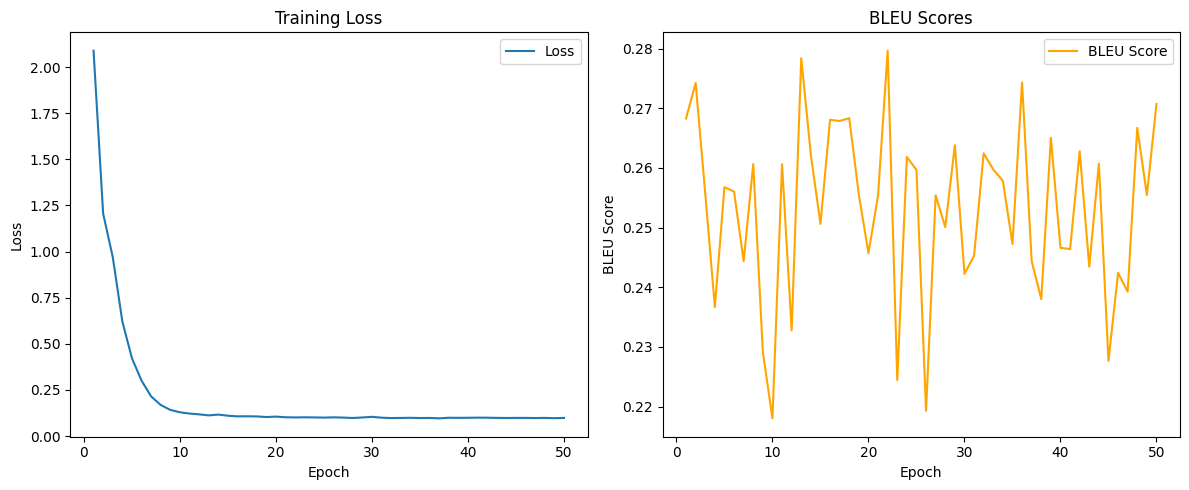

Training completed.


In [8]:
from torch.utils.data import Dataset
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch
import os
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import math

# Define a path to save the trained model
MODEL_PATH = "chatbot_model.pt"

class ChatData(Dataset):
    def __init__(self, path:str, tokenizer):
        self.data = pd.read_csv('Questions_Canada.csv', encoding='unicode_escape')
        self.X = []

        for idx, row in self.data.iterrows():
            self.X.append('<startofstring> ' + row['question'] + ' <bot>: ' + row['answer'] + ' <endofstring>')

        self.X_encoded = tokenizer(self.X, max_length=100, truncation=True, padding="max_length", return_tensors="pt")
        self.input_ids = self.X_encoded['input_ids']
        self.attention_mask = self.X_encoded['attention_mask']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx]
        }

# Calculate BLEU score
def calculate_bleu_score(candidate_responses, reference_responses):
    bleu_scores = []
    for candidate_response, reference_response in zip(candidate_responses, reference_responses):
        bleu_score = sentence_bleu([reference_response], candidate_response)
        bleu_scores.append(bleu_score)
    return bleu_scores

# Evaluate perplexity
def calculate_perplexity(text, model, tokenizer, device):
    input_ids = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=100)
    attention_mask = input_ids.ne(0)  # Create attention mask
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask, labels=input_ids)
    loss = output.loss
    perplexity = math.exp(loss)
    return perplexity

def train(chatData, model, optimizer, device, model_path, reference_responses, epochs=50):
    loss_values = []  # To store loss values
    bleu_scores = []  # To store BLEU scores

    for i in tqdm(range(epochs)):
        total_loss = 0
        candidate_responses = []

        for data in chatData:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            optimizer.zero_grad()
            output = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = output.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Generate responses during training
            generated_response = model.generate(input_ids, attention_mask=attention_mask, max_length=150, num_return_sequences=1, no_repeat_ngram_size=2)
            response = tokenizer.decode(generated_response[0], skip_special_tokens=True)
            candidate_responses.append(response)

        # Calculate BLEU scores for the epoch
        epoch_bleu_scores = calculate_bleu_score(candidate_responses, reference_responses)
        average_bleu_score = sum(epoch_bleu_scores) / len(epoch_bleu_scores)
        bleu_scores.append(average_bleu_score)

        # Log and print the loss for the epoch
        print(f"Epoch {i + 1}/{epochs} - Loss: {total_loss:.4f} - BLEU Score: {average_bleu_score:.4f}")

        # Append the loss values to the list for plotting
        loss_values.append(total_loss)

        # Save the model and its configuration after each epoch
        model.save_pretrained(model_path)  # Save both weights and configuration
        tokenizer.save_pretrained(model_path)  # Save tokenizer's configuration

    # Plot loss and BLEU scores
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss_values, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, bleu_scores, label='BLEU Score', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('BLEU Score')
    plt.legend()
    plt.title('BLEU Scores')

    plt.tight_layout()
    plt.show()

    print("Training completed.")

# Load or initialize the model
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({"pad_token": "<pad>",
                            "bos_token": "<startofstring>",
                            "eos_token": "<endofstring>"})
tokenizer.add_tokens(["<bot>:"])

if os.path.exists(MODEL_PATH):
    model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)
else:
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    model.resize_token_embeddings(len(tokenizer))

model = model.to(device)
chatData = ChatData("Questions_Canada.csv", tokenizer)
chatData = DataLoader(chatData, batch_size=64)
model.train()


optimizer = Adam(model.parameters(), lr=1e-3)

# Define reference responses for BLEU score calculation
reference_responses = [
    "For immigration to Canada, you may need to go through a series of steps. These include determining your eligibility, creating an Express Entry profile, and submitting your application. Ensure you meet the required criteria before proceeding."
]

print("Training ...")
train(chatData, model, optimizer, device, MODEL_PATH, reference_responses)


In [9]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

MODEL_PATH = "chatbot_model.pt"

# MODEL_PATH = "model_state.pt"

def infer(inp, model, tokenizer, device):
    inp = "<startofstring> " + inp + " <bot>: "
    inp = tokenizer(inp, return_tensors="pt")
    X = inp["input_ids"].to(device)
    a = inp["attention_mask"].to(device)

    output = model.generate(X, attention_mask=a)
    output = tokenizer.decode(output[0])
    return output

def main():
    # Load the trained model
    device = "cuda" if torch.cuda.is_available() else "cpu"

    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.add_special_tokens({"pad_token": "<pad>",
                                "bos_token": "<startofstring>",
                                "eos_token": "<endofstring>"})
    tokenizer.add_tokens(["<bot>:"])

    # model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)
    model = GPT2LMHeadModel.from_pretrained(pretrained_model_name_or_path=MODEL_PATH, local_files_only=True)
    model = model.to(device)
    model.eval()

    print("Chat with the chatbot. Type 'exit' to end the conversation.")
    while True:
        inp = input("You: ")
        if inp == 'exit':
            break
        response = infer(inp, model, tokenizer, device)
        print(f"Chatbot: {response}")

if __name__ == "__main__":
    main()


Chat with the chatbot. Type 'exit' to end the conversation.
Chatbot: <startofstring> do i need visa for canada?  <bot>:   <bot>:  Yes. To apply for a temporary
Chatbot: <startofstring> visa  <bot>:   <bot>:  Yes, you can sponsor a visa or an Electronic Travel authorization (e


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
